In [1]:
# Loading dependencies.
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
import time


In [2]:
# Path to csv.
card_fraud_path_load = Path("resource/merged_file.csv")
card_data = pd.read_csv(card_fraud_path_load)
card_data.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,09/31,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
1,001538cf-4b3c-4d81-9cce-fb74fa5c6427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-11 15:30:47,2895.00,...,01/25,1e68ed4e3d58a51096a7feea3947f40debf1fd9246ec97...,12,0,2,Online,102.205.87.49,Desktop,ukhanna,Assumenda amet corporis consectetur asperiores...
2,0016926c-d82a-4070-a0ad-cd1416674744,210.63.242.180,Taipei City,25.05437,121.60681,Asia,Taipei,Taipei,2023-07-16 01:16:14,1492.48,...,12/31,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,5,1,2,In-Person,210.63.242.180,Tablet,NaN,Officiis incidunt minima magnam. Explicabo exp...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,03/25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
4,003014ef-45b3-4743-bc6f-adab9a91a037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-12 03:15:14,2470.89,...,01/30,533eb9a8909f614c351b65e6b8aba1ffc2890735ce9a8a...,12,0,3 or more,Online,205.60.134.240,Desktop,wagletushar,Deserunt fugit impedit odio molestiae reiciend...


In [3]:
# General info on data.
card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Transaction ID                           8000 non-null   object 
 1   IP                                       3989 non-null   object 
 2   City                                     3980 non-null   object 
 3   Lat                                      3989 non-null   float64
 4   Lng                                      3989 non-null   float64
 5   Continent                                3989 non-null   object 
 6   Capital                                  3989 non-null   object 
 7   Country                                  3989 non-null   object 
 8   Transaction Date and Time                8000 non-null   object 
 9   Transaction Amount                       8000 non-null   float64
 10  Cardholder Name                          8000 no

In [4]:
# Counted how many (potential) fraud or valid transactions there are in the data.
fraud_data = card_data[card_data['Fraud Flag or Label'] == 1]
fraud_data_count = len(fraud_data)
valid_data_row = card_data[card_data['Fraud Flag or Label'] == 0]
valid_data_count = len(valid_data_row)
print(f"There are {fraud_data_count} fraud or flag or labeled transactions in the dataset.")
print(f"There are {valid_data_count} valid transactions in the dataset.")

There are 3989 fraud or flag or labeled transactions in the dataset.
There are 4011 valid transactions in the dataset.


In [5]:
card_data['Cardholder Name'].value_counts()

Cardholder Name
Mamooty Chaudhuri      3
Eva Balasubramanian    3
Tiya Dugar             3
Trisha Ghose           3
Zara Rajagopalan       3
                      ..
Aaina Hayre            1
Aarush Dar             1
Himmat Hayer           1
Hunar Chaudhuri        1
Shaan Borah            1
Name: count, Length: 7651, dtype: int64

In [6]:
# Cardholder names that has fraud or flag or labeled transactions. (more than 1 means multiple transactions.)
fraudulent_cardholder = fraud_data.groupby(['Cardholder Name']).size()
fraudulent_cardholder.sort_values(ascending=False)

Cardholder Name
Tiya Dugar       3
Arhaan Kata      2
Gatik Sethi      2
Dhanuk Sekhon    2
Dhanuk Doshi     2
                ..
Hiran Talwar     1
Hiran Tandon     1
Hridaan Bains    1
Hridaan Brar     1
Zoya Yadav       1
Length: 3900, dtype: int64

In [7]:
# Checking to see if there is any null value in the column.
card_data['Transaction Date and Time'].isnull().sum()

0

In [8]:
# Formatted the column into a date form.
card_data_transaction_date = pd.to_datetime(card_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')
card_data_expiration_date = pd.to_datetime(card_data['Card Expiration Date'], format='%m/%y')

card_data_transaction_date.head()

0   2021-03-28 12:02:22
1   2022-06-11 15:30:47
2   2023-07-16 01:16:14
3   2021-12-08 15:57:04
4   2023-07-12 03:15:14
Name: Transaction Date and Time, dtype: datetime64[ns]

In [9]:
# Create a copy of the fraudulent transactions data
flagged_data = card_data[card_data['Fraud Flag or Label'] == 1].copy()

# Convert the 'Transaction Date and Time' column to datetime
flagged_data['Transaction Date and Time'] = pd.to_datetime(fraud_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')

# Extract the month and hour from the transaction date
flagged_data['Month'] = flagged_data['Transaction Date and Time'].dt.month
flagged_data['Hour'] = flagged_data['Transaction Date and Time'].dt.hour

# Group by month & hour and count the number of transactions
flagged_transactions_per_month = flagged_data.groupby('Month').size()
flagged_transactions_per_hour = flagged_data.groupby('Hour').size()


In [10]:
# Sample group by with Month and transaction ID
flagged_transactions_per_month_id = flagged_data.groupby(['Month', 'Transaction ID']).size()
flagged_transactions_per_month_id



Month  Transaction ID                      
1      006692b3-4197-4362-a3f1-bbfc9102dcb7    1
       012b028f-7b2a-4cc5-b70c-7a3c9864f7a7    1
       02252f15-53a1-41fd-b408-38c60a441754    1
       03847613-9687-4df3-a012-c914408d8412    1
       04ba5701-94fd-46c6-8497-aca2737dbda5    1
                                              ..
12     fd0bbaa5-c7ef-48ea-b1c9-b3a381b2d352    1
       fd6dda26-9338-4941-9641-8a3cb5e36970    1
       fe33e0e3-2869-4031-a209-07c3027fb799    1
       fe8a2b5f-94b0-4eb2-97d9-11e158d867f8    1
       ffff5b51-80e6-47d7-85c1-06a23aeec816    1
Length: 3989, dtype: int64

In [11]:
# Seperated all the date data into 'year', 'month', 'day'.
card_data_transaction_year = card_data_transaction_date.dt.year
card_data_transaction_month = card_data_transaction_date.dt.month
card_data_transaction_day = card_data_transaction_date.dt.day

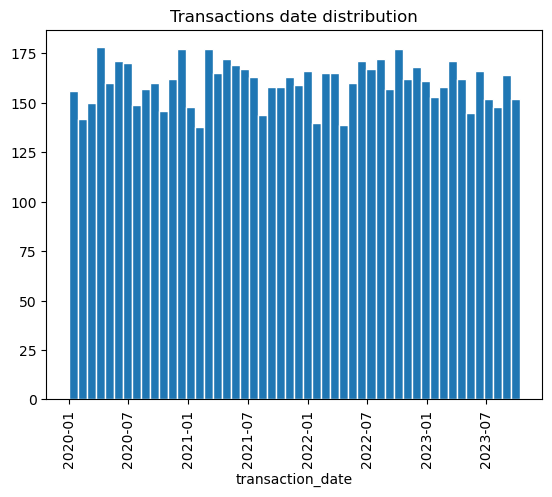

In [12]:
# Histogram for transaction date distribution.
plt.hist(card_data_transaction_date, bins=50, edgecolor='white')
plt.title("Transactions date distribution")
plt.xlabel("transaction_date")
plt.xticks(rotation=90, ha='center')
plt.show()

In [13]:
# Created new columns regarding year.
transactions_per_year = card_data.groupby(card_data_transaction_year).size()
transactions_per_year = transactions_per_year.reset_index()
transactions_per_year.columns = ['Year', 'Transaction per year']
transactions_per_year


,Year,Transaction per year
0,2020,2114
1,2021,2137
2,2022,2134
3,2023,1615


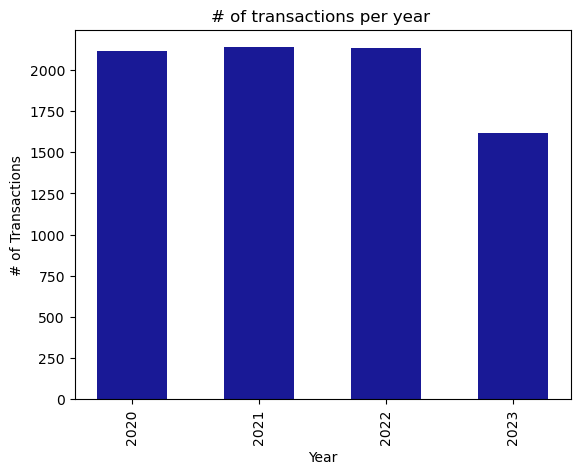

In [14]:
# Created bar graph to show transactions per year.
x_axis = transactions_per_year['Year']
y_axis = transactions_per_year['Transaction per year']

tick_locations = []

for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, y_axis, color="darkblue", alpha=0.9, align="center", width=0.55)
plt.xticks(tick_locations, rotation=90, ha='center')
plt.title("# of transactions per year ")
plt.xlabel("Year")
plt.ylabel("# of Transactions")
plt.show()

#### We can easily see that the transactions through credit card has significantly decreased on the year '2023', we believe that the after math of covid-19 has carried over until the 2020 to 2022

In [15]:
# Created new columns regarding month.
transactions_per_month = card_data.groupby(card_data_transaction_month).size()
transactions_per_month = transactions_per_month.reset_index()
transactions_per_month.columns = ['Month', 'Transactions per month']
transactions_per_month

,Month,Transactions per month
0,1,672
1,2,634
2,3,747
3,4,670
4,5,743
5,6,721
6,7,710
7,8,710
8,9,721
9,10,569


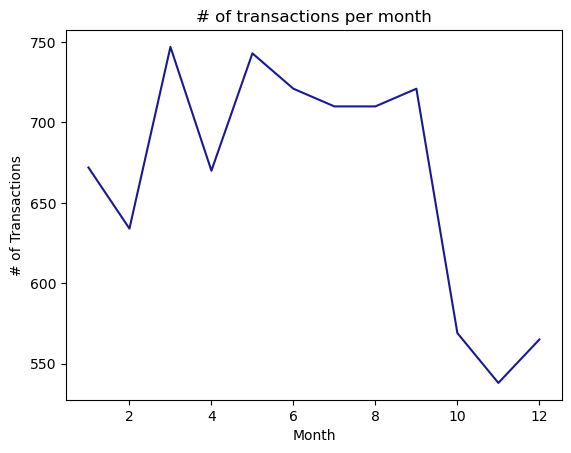

In [16]:
# Created bar graph to show transactions per month. (1 = January)
x_axis = transactions_per_month['Month']
y_axis = transactions_per_month['Transactions per month']

plt.plot(x_axis, y_axis, color="darkblue", alpha=0.9)
plt.title("# of transactions per month")
plt.xlabel("Month")
plt.ylabel("# of Transactions")
plt.show()

#### Based on the yearly transaction graph, we dig little deeper and look at the trends on monthly transactions. Surprisingly, the amount of transactions from users significantly dips on the September and going into the end of the year.

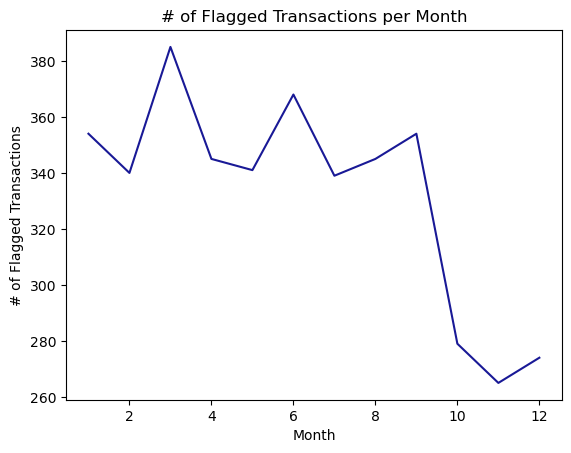

In [17]:
# Plot the number of fraudulent transactions per month
x_axis = flagged_transactions_per_month.index
y_axis = flagged_transactions_per_month.values

plt.plot(x_axis, y_axis, color="darkblue", alpha=0.9)
plt.title("# of Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Flagged Transactions")
plt.show()

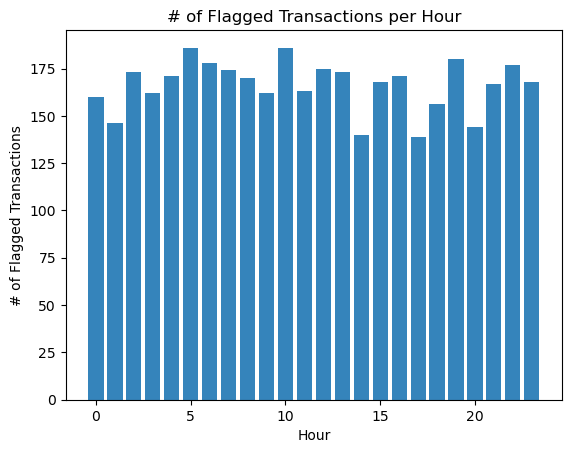

In [18]:
# Created bar graph
x_axis = flagged_transactions_per_hour.index
y_axis = flagged_transactions_per_hour.values

plt.bar(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Hour")
plt.xlabel("Hour")
plt.ylabel("# of Flagged Transactions")
plt.show()


#### Based on this bar graph we can see that 5:00am, 10:00am, 7:00pm has the highest flagged transactions; therefore, as a credit card company they need to staff the customer support agents to appropriate time slot. 

The r_value is: -0.7438931510673467


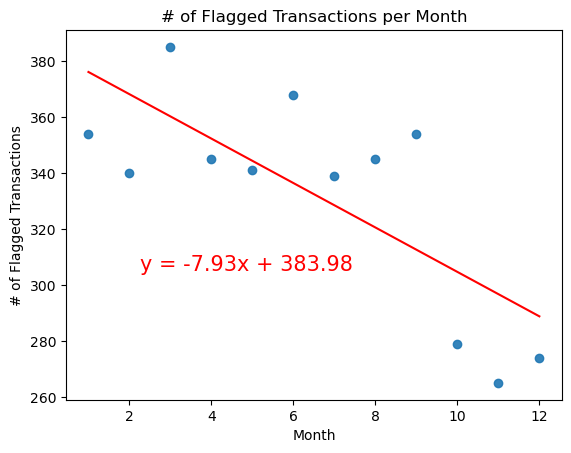

In [19]:
# Aggregate the data to get the total count of fraudulent transactions per month
fraud_transactions_per_month_id_0 = flagged_transactions_per_month_id.groupby(level=0).count()

x_axis = fraud_transactions_per_month_id_0.index
y_axis = fraud_transactions_per_month_id_0.values

# Perform linear regression
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)

# Create equation of line to calculate predicted fraudulent transaction
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Generate a scatter plot of fraudulent transactions over months
plt.scatter(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Flagged Transactions")

# Plot the regression line
plt.plot(x_axis, intercept + slope*x_axis, 'r', label='fitted line')

# Annotate the plot with the linear equation
plt.annotate(line_eq, xy=(0.15, 0.35), xycoords='axes fraction', fontsize=15, color="red")

print(f"The r_value is: {r_value}")

plt.show()

#### The r-value of -0.74 suggest that there is a strong negative correlation between the month (x-axis) and the number of flagged transactions (y-axis). This means that as time progresses, the number of flagged transactions tends to decrease. For each month that passes, the model predicts approximately 7.93 fewer flagged transactions. However, this is a simple model and doesn’t prove causation, so other factors could also be influencing the decrease in flagged transactions.